1. Загрузите изображение в оттенках серого sar_1_gray.jpg
2. постройте гистограмму
3. реализуйте алгоритм гамма коррекции с параметром гамма <1, >1
4. Сравните исходное изображение, скорректированное при помощи гамма-фильтра. MSE, SSIM
5. реализуйте алгоритм статистической цветокоррекции на основе статистики eq_gray
6. Протестируйте работу алгоритмов пороговой фильтрации с различными параметрами

Для каждого решения - напечатайте результат

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. Загрузите изображение в оттенках серого sar_1_gray.jpg

In [2]:
image = cv2.imread('lab1/sar_1_gray.jpg') # because I run ipykernel...
image.shape

(400, 600, 3)

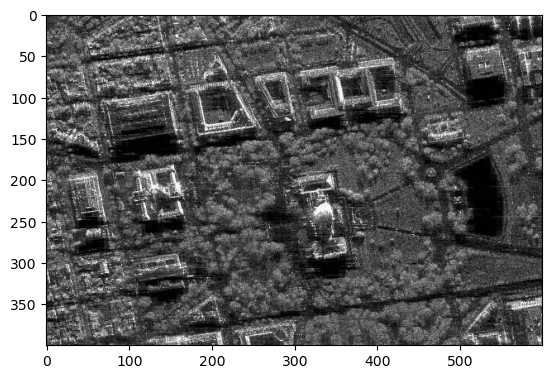

In [3]:
plt.imshow(image)

Изображение уже в grayscale, так что можно взять любой из rgb каналов для подсчета (r == g == b)

In [4]:
def show_grayscale(image, ax=plt):
    ax.axis('off')
    return ax.imshow(image, cmap="gray", vmin=0, vmax=255)

In [5]:
assert((image[:,:,0] == image[:,:,1]).all())
assert((image[:,:,1] == image[:,:,2]).all())
# assert((image[:,:,0] == image[:,:,1] == image[:,:,2]).all()) # doesn't work :c
image = image[:,:,0]

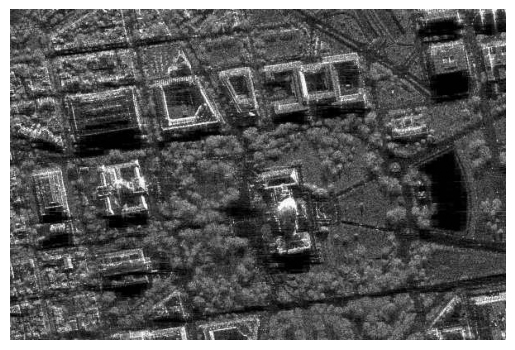

In [6]:
show_grayscale(image)

# 2. постройте гистограмму

240000.0


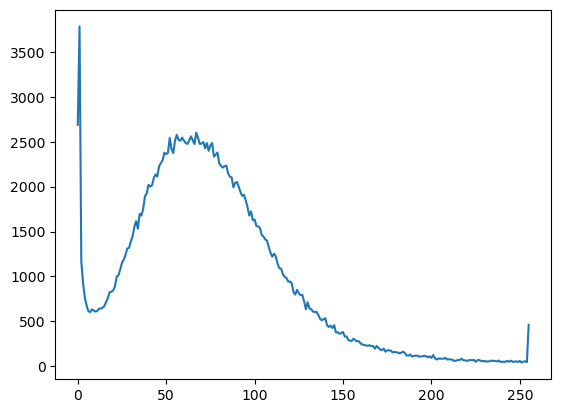

In [7]:
histSize = 256
histRange = (0, 256)
accumulate = False

img_hist = cv2.calcHist([image], [0], None, [histSize], histRange, accumulate=accumulate)
print(np.sum(img_hist))
plt.plot(img_hist)

## Кумулятивная кривая

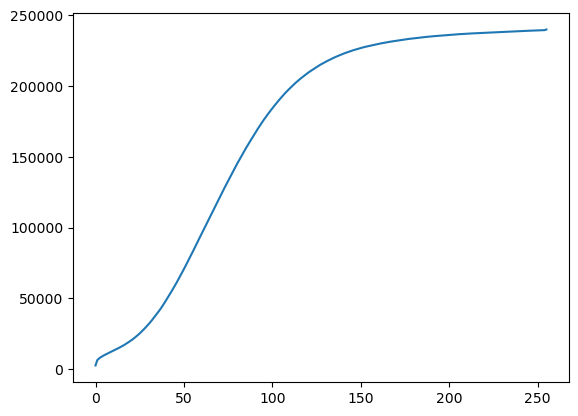

In [8]:
img_hist_cum = img_hist.cumsum()
plt.plot(img_hist_cum)

0.99999994


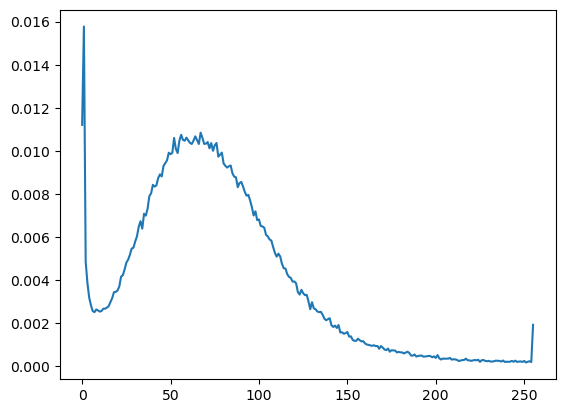

In [9]:
img_hist_norm = img_hist / (image.shape[0] * image.shape[1])
print(np.sum(img_hist_norm))
plt.plot(img_hist_norm)

# 3. реализуйте алгоритм гамма коррекции с параметром гамма <1, >1

In [10]:
def do_gamma_correction(image, gamma):
    return ((image/255.0)**gamma*255.0).astype(np.uint8)
def show_gamma_correction(image, gamma):
    return show_grayscale(do_gamma_correction(image, gamma))

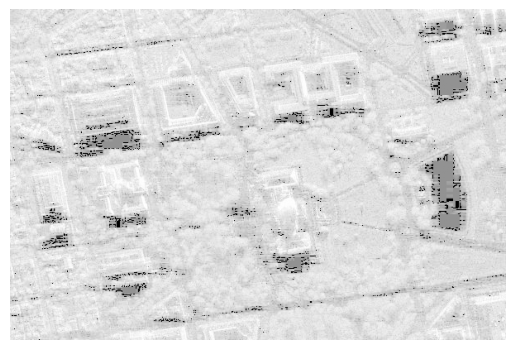

In [11]:
show_gamma_correction(image, 0.1)

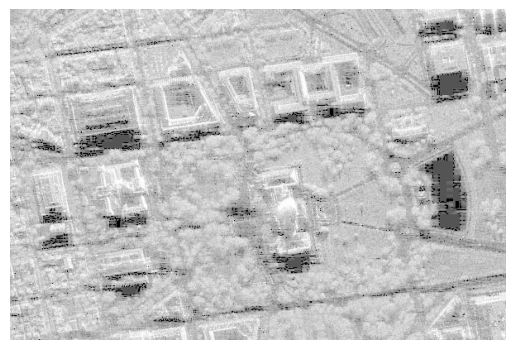

In [12]:
show_gamma_correction(image, 0.2)

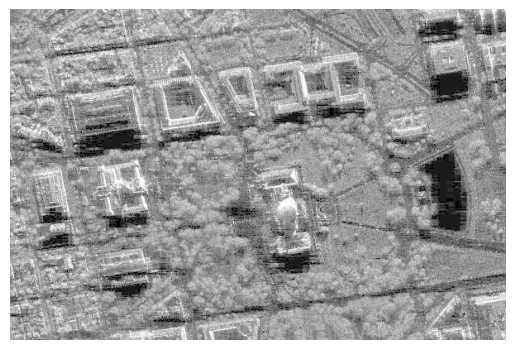

In [13]:
show_gamma_correction(image, 0.4)

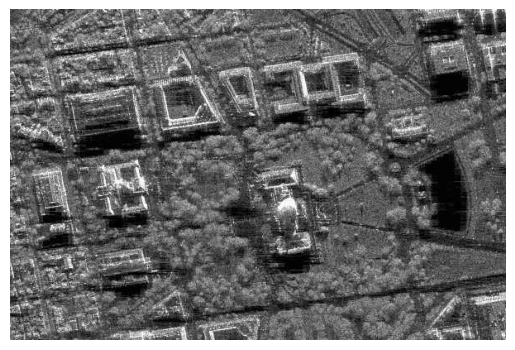

In [14]:
show_gamma_correction(image, 0.8)

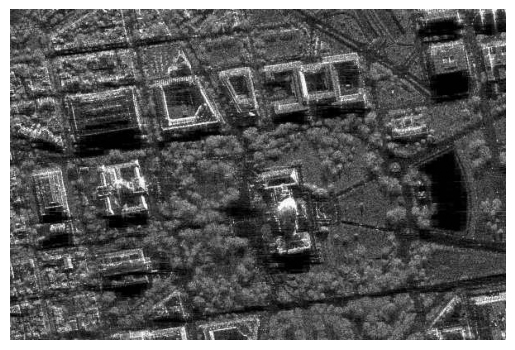

In [15]:
show_gamma_correction(image, 1.0)

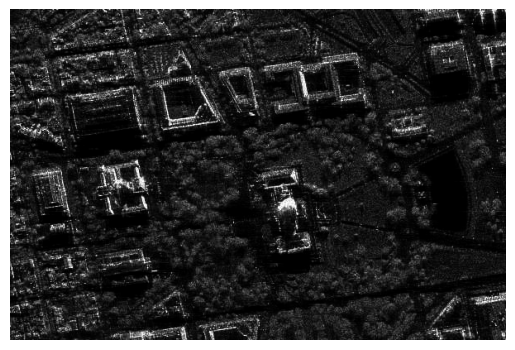

In [16]:
show_gamma_correction(image, 2.0)

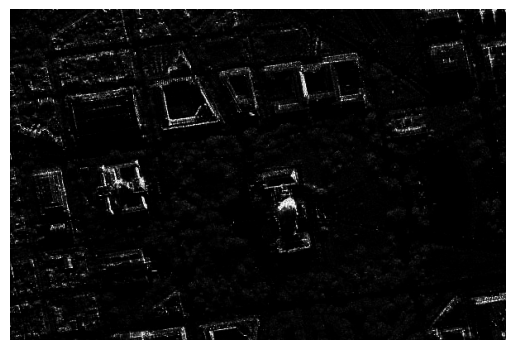

In [17]:
show_gamma_correction(image, 4.0)

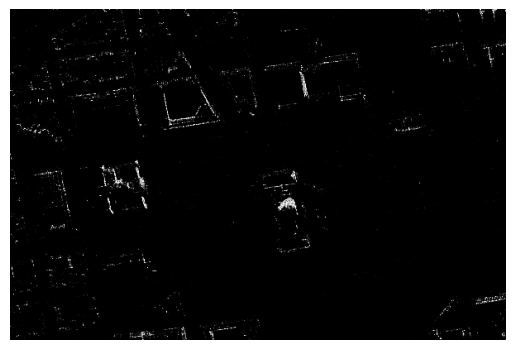

In [18]:
show_gamma_correction(image, 8.0)

# 4. Сравните исходное изображение, скорректированное при помощи гамма-фильтра. MSE, SSIM

## Графики MSE и SSIM для разных значений гамма

In [19]:
from skimage.metrics import structural_similarity, mean_squared_error
import numpy as np

def compare_gamma(image, gamma_range, metric) -> list[list, list]:
    """
    @desc graphs for metric comparing gamma correction in range. x - gamma, y - metric (e.g. MSE or SSIM)
    @param image grayscale image
    @param gamma_range `[lower, upper, step]`, 0 < lower < upper, step > 0
    @param metric def metric(image1, image2) -> value
    @return list[list[gammas], list[metric_values]]
    """
    assert(len(gamma_range) == 3)
    assert(0 < gamma_range[0] < gamma_range[1])
    assert(gamma_range[2] > 0)
    res = [[], []]
    for gamma in np.arange(gamma_range[0], gamma_range[1] + gamma_range[2], gamma_range[2]):
        image_gamma = do_gamma_correction(image, gamma)
        value = metric(image, image_gamma)
        res[0].append(gamma)
        res[1].append(value)
    return res

def compare_gamma_mass(image, below_1: list[3], above_1: list[3], separate_below_above_1: bool = False) -> dict[str, list[list, list]]:
    """
    @desc MSE and SSIM graphs for comparing gamma correction in range. x - gamma, y - metric (MSE or SSIM)
    @param image grayscale image
    @param below_1 `[lower, upper, step]`, 0 < lower < upper <= 1, step > 0 can be `None`
    @param above_1 `[lower, upper, step]`, 1 <= lower < upper, step > 0 can be `None`
    @param separate_below_above_1 See @return
    @return dict{"metric": list[list[gammas], list[metric_values]]} if separate_below_above_1==False
    @return dict{"metric": list[]}
    """
    def ssim_wrapper(image1, image2):
        return structural_similarity(image1, image2, full=False, data_range=np.uint8(255))
    res = {}
    for metric_name, metric in (["MSE", mean_squared_error], ["SSIM", ssim_wrapper]):
        #res[metric_name] = [[], []]
        res[metric_name] = [[[], []], [[], []]]
        if below_1 is not None:
            assert(len(below_1) == 3)
            assert(0 < below_1[0] < below_1[1] <= 1)
            compare_res = compare_gamma(image, below_1, metric)
            res[metric_name][0][0] += compare_res[0]
            res[metric_name][0][1] += compare_res[1]
            #res[metric_name][0] += compare_res[0]
            #res[metric_name][1] += compare_res[1]
        if above_1 is not None:
            assert(len(above_1) == 3)
            assert(1 <= above_1[0] < above_1[1])
            compare_res = compare_gamma(image, above_1, metric)
            res[metric_name][1][0] += compare_res[0]
            res[metric_name][1][1] += compare_res[1]
            #res[metric_name][0] += compare_res[0]
            #res[metric_name][1] += compare_res[1]
    if not separate_below_above_1:
        for key, data in res.items():
            res_new = [data[0][0] + data[1][0], data[0][1] + data[1][1]]
            res[key] = res_new
    return res

In [20]:
gamma_compare_data = compare_gamma_mass(image, [0.1, 0.9, 0.1], [2, 10, 1])
gamma_compare_data_separated = compare_gamma_mass(image, [0.1, 0.9, 0.1], [2, 10, 1], True)

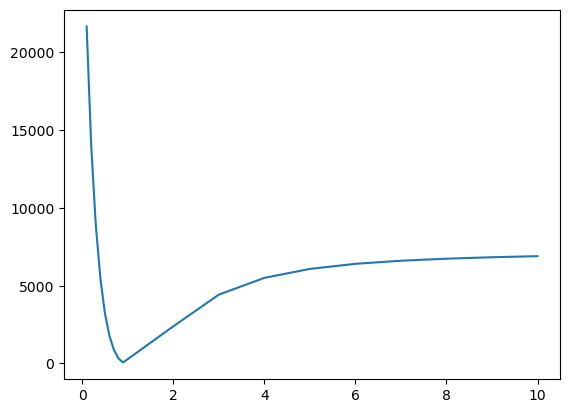

In [21]:
plt.plot(*gamma_compare_data["MSE"])

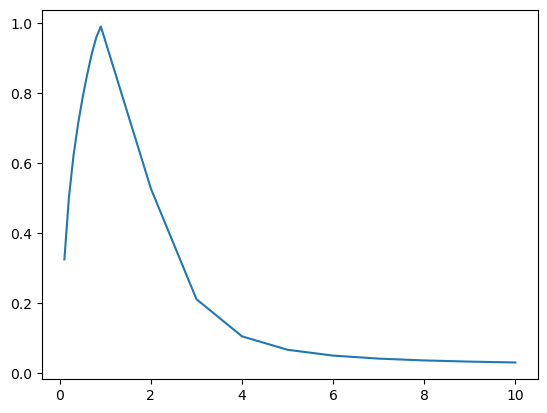

In [22]:
plt.plot(*gamma_compare_data["SSIM"])

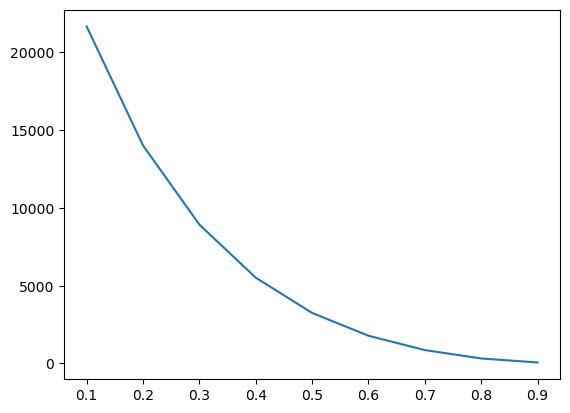

In [23]:
plt.plot(*gamma_compare_data_separated["MSE"][0])

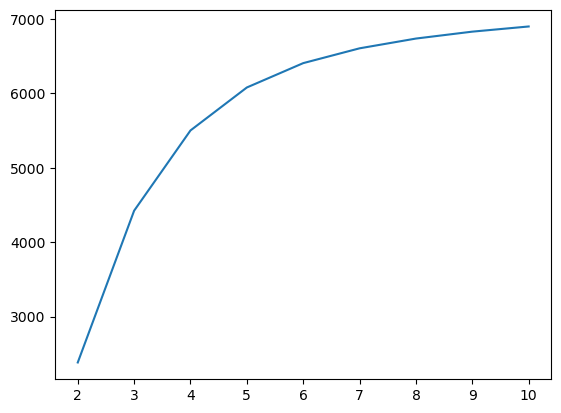

In [24]:
plt.plot(*gamma_compare_data_separated["MSE"][1])

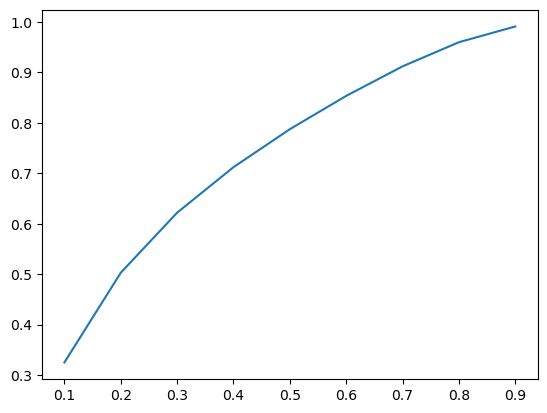

In [25]:
plt.plot(*gamma_compare_data_separated["SSIM"][0])

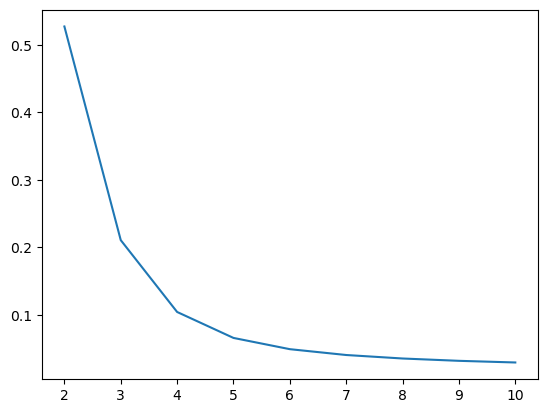

In [26]:
plt.plot(*gamma_compare_data_separated["SSIM"][1])

## Некоторые ssim diff

In [27]:
def gamma_ssim_diff_plot(image, gamma):
    image_gamma = do_gamma_correction(image, gamma)
    (ssim, diff) = structural_similarity(image, image_gamma, full=True, data_range=np.uint8(255))
    mse = mean_squared_error(image, image_gamma)
    print(f"Gamma: {gamma}, SSIM: {ssim}, MSE: {mse}")
    diff = (diff * 255).astype("uint8")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Gamma: {gamma}, SSIM: {ssim}, MSE: {mse}")
    show_grayscale(image_gamma, ax1)
    #ax2.imshow(diff)
    show_grayscale(diff, ax2)

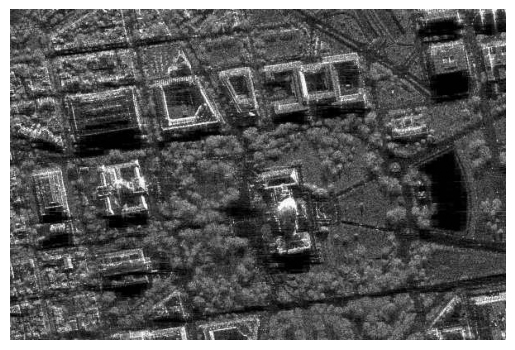

In [28]:
show_grayscale(image)

Gamma: 0.1, SSIM: 0.3247689519986237, MSE: 21665.039608333333


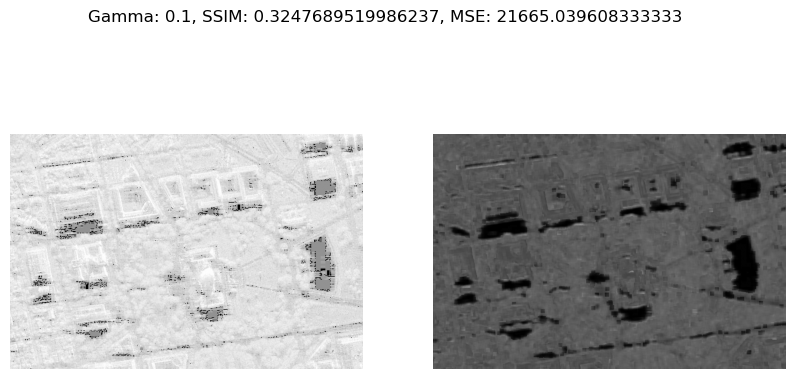

In [29]:
gamma_ssim_diff_plot(image, 0.1)

Gamma: 0.2, SSIM: 0.5027413411391763, MSE: 14018.052908333333


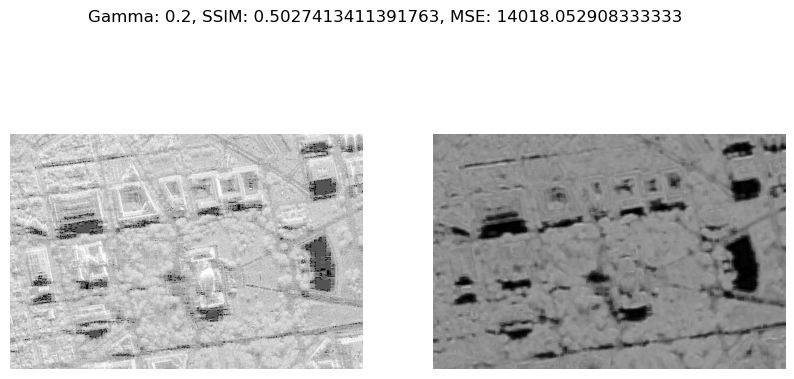

In [30]:
gamma_ssim_diff_plot(image, 0.2)

Gamma: 0.4, SSIM: 0.7121390473843303, MSE: 5517.938070833334


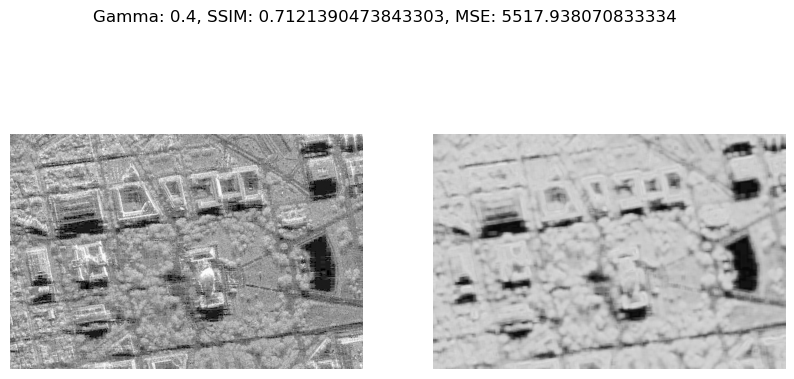

In [31]:
gamma_ssim_diff_plot(image, 0.4)

Gamma: 0.8, SSIM: 0.9599999221842972, MSE: 323.20532083333336


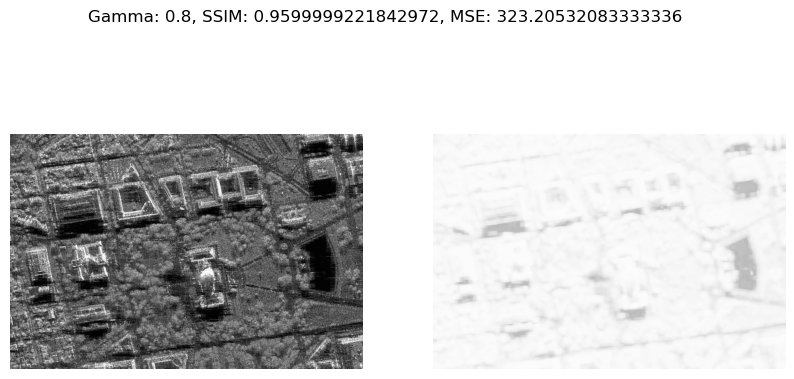

In [32]:
gamma_ssim_diff_plot(image, 0.8)

Gamma: 1.0, SSIM: 1.0, MSE: 0.0


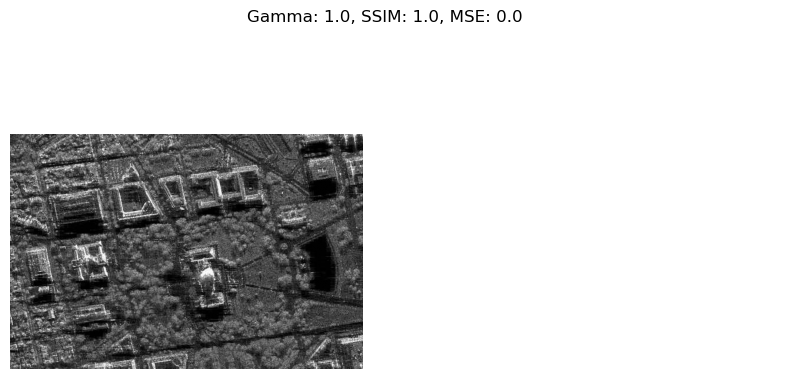

In [33]:
gamma_ssim_diff_plot(image, 1.0)

Gamma: 2.0, SSIM: 0.5270459922820343, MSE: 2383.7636375


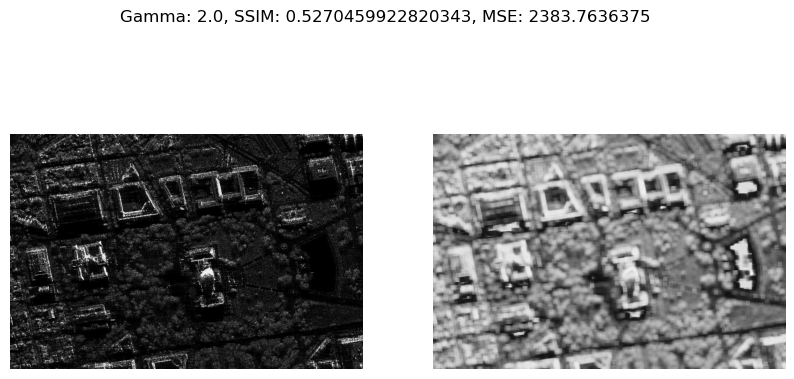

In [34]:
gamma_ssim_diff_plot(image, 2.0)

Gamma: 4.0, SSIM: 0.10456269029688792, MSE: 5502.7575541666665


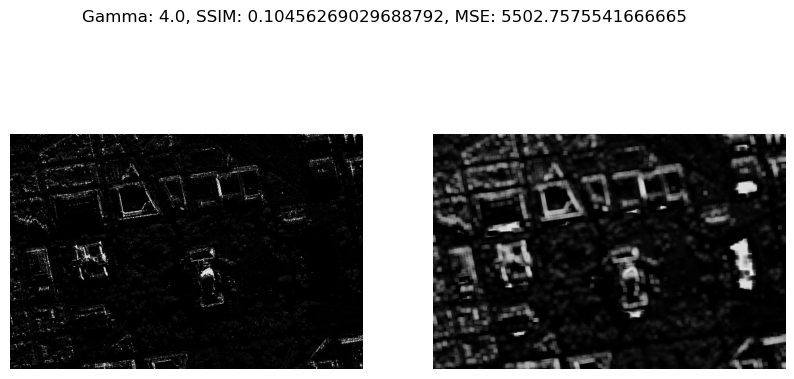

In [35]:
gamma_ssim_diff_plot(image, 4.0)

Gamma: 8.0, SSIM: 0.03571171376733927, MSE: 6737.7419291666665


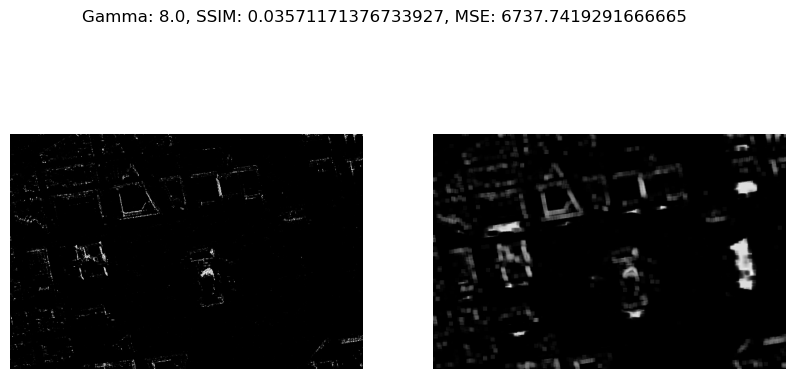

In [36]:
gamma_ssim_diff_plot(image, 8.0)

# 5. реализуйте алгоритм статистической цветокоррекции на основе статистики eq_gray

In [37]:
mean = image.mean()
std = image.std()
print(mean, std)

74.94157083333333 43.658465466227916


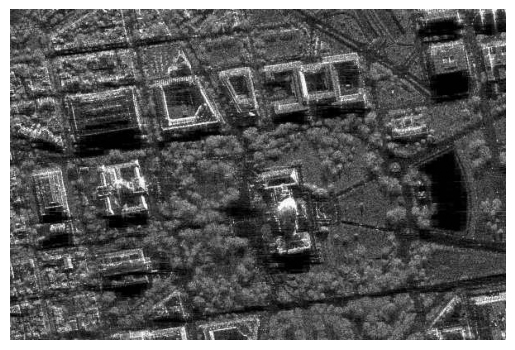

In [38]:
show_grayscale(image)

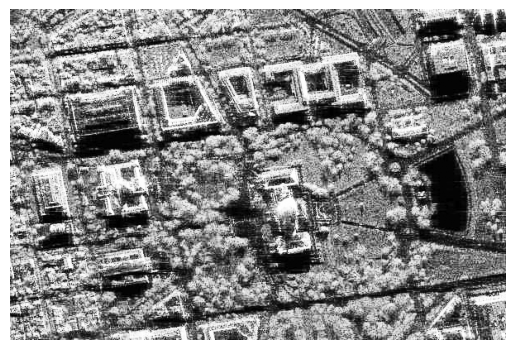

In [39]:
eq_gray = cv2.equalizeHist(image)
show_grayscale(eq_gray)

In [40]:
def statistic_color_correction(image_orig, image_corr):
    return image_corr.mean() + (image_orig - image_orig.mean()) / image_orig.std() * image_corr.std()

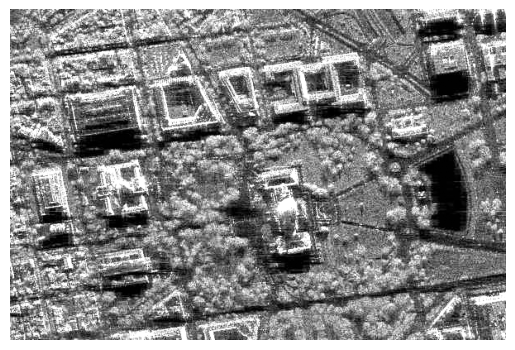

In [41]:
statistic_corrected_img = statistic_color_correction(image, eq_gray)
show_grayscale(statistic_corrected_img)

# 6. Протестируйте работу алгоритмов пороговой фильтрации с различными параметрами

In [42]:
def threshold_binary(image, thresh):
    _image = image.copy()
    _image[image > thresh] = 255
    _image[image <= thresh] = 0
    return _image
def threshold_binary_inv(image, thresh):
    _image = image.copy()
    _image[image > thresh] = 0
    _image[image <= thresh] = 255
    return _image
def threshold_trunc(image, thresh):
    _image = image.copy()
    _image[image > thresh] = thresh
    return _image
def threshold_to_zero(image, thresh):
    _image = image.copy()
    _image[image <= thresh] = 0
    return _image
def threshold_to_zero_inv(image, thresh):
    _image = image.copy()
    _image[image > thresh] = 0
    return _image

In [43]:
def show_threshold_filters(image, thresholds, filter, rows=1):
    if (len(thresholds) == 1):
        filtered_image = filter(image, thresholds[0])
        show_grayscale(filtered_image)
        return
    columns = np.ceil(len(thresholds) / rows, dtype=np.uint, casting="unsafe")
    fig, axes = plt.subplots(rows, columns, figsize=(rows * 10, columns * 2))
    for i, threshold in enumerate(thresholds):
        filtered_image = filter(image, threshold)
        show_grayscale(filtered_image, axes[i])


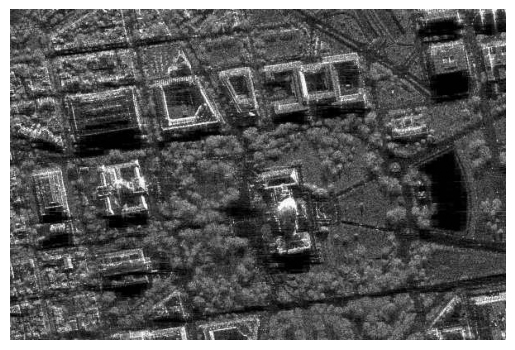

In [44]:
show_grayscale(image)

In [45]:
selected_thresholds = [64, 128, 192]

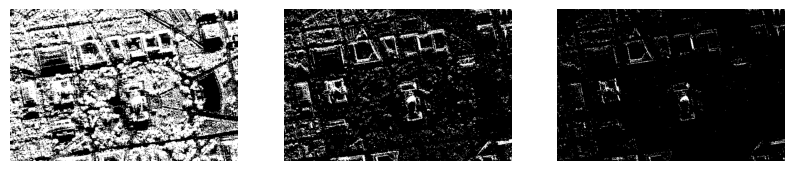

In [46]:
show_threshold_filters(image, selected_thresholds, threshold_binary)

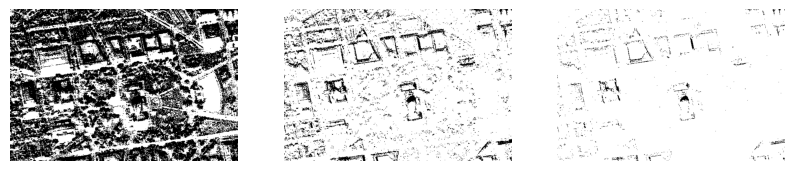

In [47]:
show_threshold_filters(image, selected_thresholds, threshold_binary_inv)

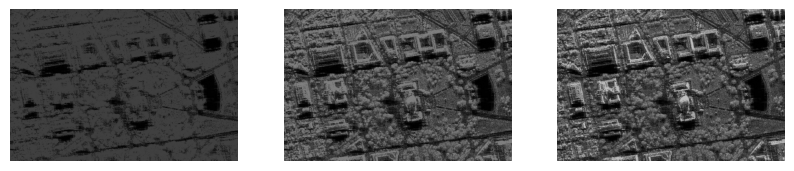

In [48]:
show_threshold_filters(image, selected_thresholds, threshold_trunc)

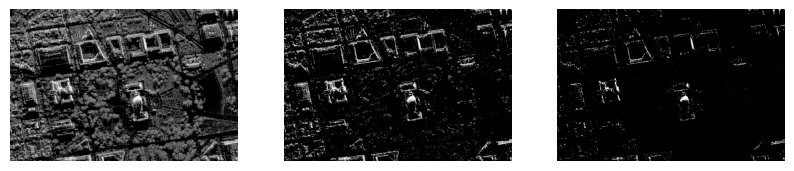

In [49]:
show_threshold_filters(image, selected_thresholds, threshold_to_zero)

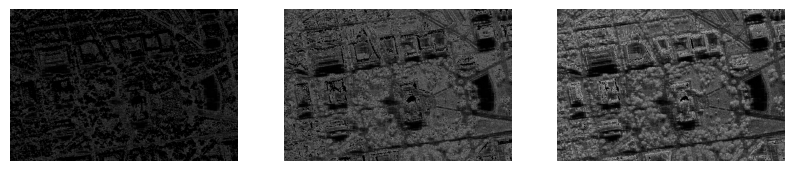

In [50]:
show_threshold_filters(image, selected_thresholds, threshold_to_zero_inv)

## test

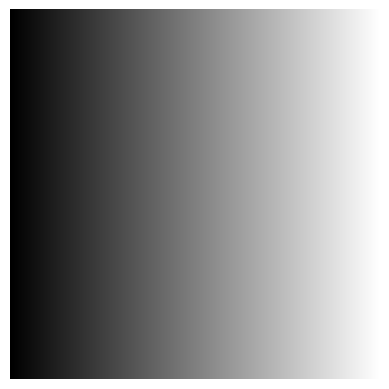

In [51]:
gray_grad = np.zeros((256, 256), dtype=np.uint8)
for i in range(0, 256):
    gray_grad[:, i] = i
show_grayscale(gray_grad)

In [52]:
gray_grad_threshold = [128]

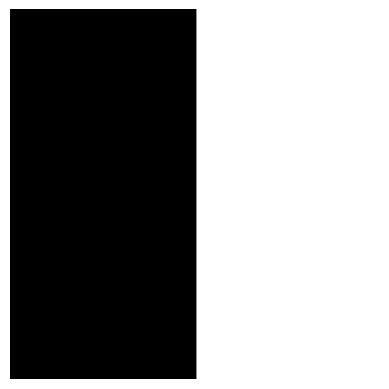

In [53]:
show_threshold_filters(gray_grad, gray_grad_threshold, threshold_binary)

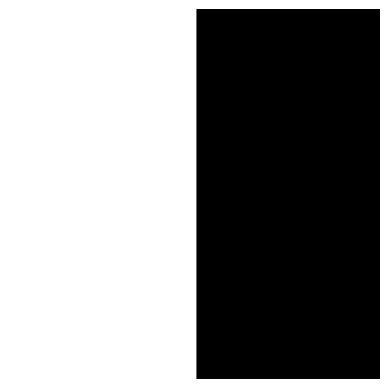

In [54]:
show_threshold_filters(gray_grad, gray_grad_threshold, threshold_binary_inv)

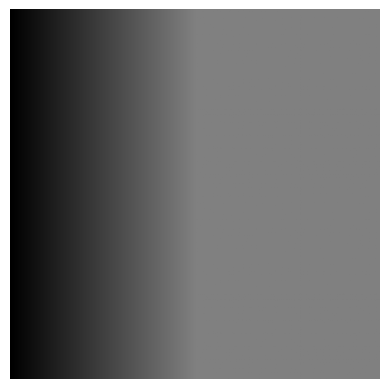

In [55]:
show_threshold_filters(gray_grad, gray_grad_threshold, threshold_trunc)

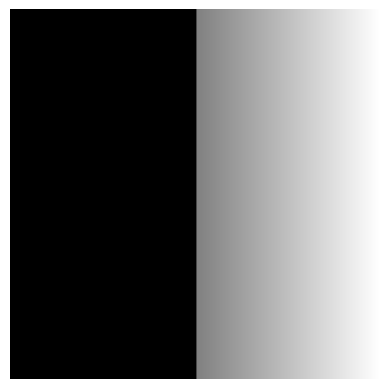

In [56]:
show_threshold_filters(gray_grad, gray_grad_threshold, threshold_to_zero)

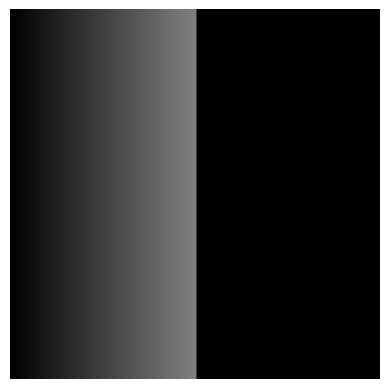

In [57]:
show_threshold_filters(gray_grad, gray_grad_threshold, threshold_to_zero_inv)